In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

class PressureImageDataset:
    def __init__(self, pressure_dir, target_size=(32, 64)):
        self.pressure_dir = pressure_dir
        self.target_size = target_size
        self.images = []
        self.labels = []

        # Collect pressure image paths and labels
        for patient_folder in os.listdir(pressure_dir):
            patient_path_pressure = os.path.join(pressure_dir, patient_folder, 'PM', 'uncover')
            if os.path.isdir(patient_path_pressure):
                pressure_images = sorted([f for f in os.listdir(patient_path_pressure) if f.endswith('.png')])
                for pressure_img in pressure_images:
                    img_path = os.path.join(patient_path_pressure, pressure_img)
                    img = Image.open(img_path).convert('RGB').resize(self.target_size)  # Convert to RGB and resize
                    self.images.append(np.array(img))
                    self.labels.append(self._get_label_from_filename(pressure_img))  # Get the label

        # Convert lists to numpy arrays
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

        print(f"Number of images: {self.images.shape[0]}, Image shape: {self.images.shape[1:]}")
        print(f"Number of labels: {len(self.labels)}")

    def _get_label_from_filename(self, filename):
        value_str = filename.rsplit('_', 1)[-1].split('.')[0]
        value = int(value_str)
        if 1 <= value <= 15:
            return 0  # supine
        elif 16 <= value <= 30:
            return 2  # right
        elif 31 <= value <= 45:
            return 1  # left
        else:
            raise ValueError(f"Value {value} is outside the expected range for {filename}")

    def get_data(self):
        return self.images, self.labels

# Initialize the dataset
pressure_dir = 'D:/SLP2022/SLP/danaLab'
dataset = PressureImageDataset(pressure_dir, target_size=(32, 64))

# Get images and labels
images, posture_labels = dataset.get_data()

# Split data into training and validation sets
X = np.array(images)
y = np.array(posture_labels)
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize pixel values to the range [0, 1]
x_train = x_train / 255.0
x_val = x_val / 255.0



Number of images: 4590, Image shape: (64, 32, 3)
Number of labels: 4590


Number of images: 4590, Image shape: (64, 32, 3)
Number of labels: 4590


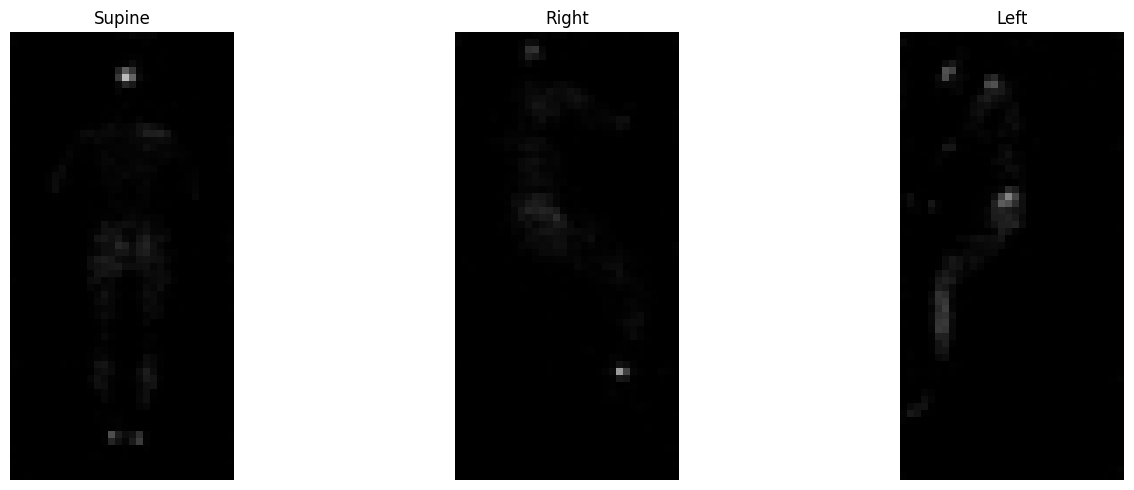

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

class PressureImageDataset:
    def __init__(self, pressure_dir, target_size=(32, 64)):
        self.pressure_dir = pressure_dir
        self.target_size = target_size
        self.images = []
        self.labels = []

        # Collect pressure image paths and labels
        for patient_folder in os.listdir(pressure_dir):
            patient_path_pressure = os.path.join(pressure_dir, patient_folder, 'PM', 'uncover')
            if os.path.isdir(patient_path_pressure):
                pressure_images = sorted([f for f in os.listdir(patient_path_pressure) if f.endswith('.png')])
                for pressure_img in pressure_images:
                    img_path = os.path.join(patient_path_pressure, pressure_img)
                    img = Image.open(img_path).convert('RGB').resize(self.target_size)  # Convert to RGB and resize
                    self.images.append(np.array(img))
                    self.labels.append(self._get_label_from_filename(pressure_img))  # Get the label

        # Convert lists to numpy arrays
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

        print(f"Number of images: {self.images.shape[0]}, Image shape: {self.images.shape[1:]}")
        print(f"Number of labels: {len(self.labels)}")

    def _get_label_from_filename(self, filename):
        value_str = filename.rsplit('_', 1)[-1].split('.')[0]
        value = int(value_str)
        if 1 <= value <= 15:
            return 0  # supine
        elif 16 <= value <= 30:
            return 2  # right
        elif 31 <= value <= 45:
            return 1  # left
        else:
            raise ValueError(f"Value {value} is outside the expected range for {filename}")

    def get_data(self):
        return self.images, self.labels

# Initialize the dataset
pressure_dir = 'D:/SLP2022/SLP/danaLab'
dataset = PressureImageDataset(pressure_dir, target_size=(32, 64))

# Get images and labels
images, posture_labels = dataset.get_data()

# Specify postures to display for subject 1
subject_id = 1
postures_to_display = [1, 16, 31]
posture_names = {1: 'Supine', 16: 'Right', 31: 'Left'}

# Create a figure to display the images
fig, axes = plt.subplots(1, len(postures_to_display), figsize=(15, 5))

# Loop through each posture and display the corresponding image
for idx, posture in enumerate(postures_to_display):
    # Select the image for the given posture
    selected_images = [images[i] for i in range(len(images)) if posture_labels[i] == (0 if posture == 1 else (2 if posture == 16 else 1))]
    
    # Randomly choose one image from the selected images
    if selected_images:
        img_to_display = random.choice(selected_images)
        
        # Plot the image
        axes[idx].imshow(img_to_display)
        axes[idx].set_title(posture_names[posture])
        axes[idx].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


In [2]:
# Create the model
from tqdm.keras import TqdmCallback


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64,32, 3)),  # RGB images, hence 3 channels
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Output layer for multiclass classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',  # Labels are not one-hot encoded
              metrics=['accuracy'])


# Train the model
history = model.fit(x_train, 
                    y_train, 
                    epochs=10, 
                    validation_data=(x_val, y_val),
                    callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10


101/101 [==============================] - 14s 102ms/step - loss: 0.3809 - accuracy: 0.8618 - val_loss: 0.1913 - val_accuracy: 0.9390
Epoch 2/10
101/101 [==============================] - 8s 82ms/step - loss: 0.1381 - accuracy: 0.9583 - val_loss: 0.0848 - val_accuracy: 0.9768
Epoch 3/10
101/101 [==============================] - 7s 66ms/step - loss: 0.0804 - accuracy: 0.9763 - val_loss: 0.0880 - val_accuracy: 0.9702
Epoch 4/10
101/101 [==============================] - 5s 52ms/step - loss: 0.0561 - accuracy: 0.9804 - val_loss: 0.0588 - val_accuracy: 0.9818
Epoch 5/10
101/101 [==============================] - 5s 51ms/step - loss: 0.0414 - accuracy: 0.9885 - val_loss: 0.0594 - val_accuracy: 0.9826
Epoch 6/10
101/101 [==============================] - 6s 63ms/step - loss: 0.0291 - accuracy: 0.9922 - val_loss: 0.0576 - val_accuracy: 0.9833
Epoch 7/10
101/101 [==============================] - 7s 68ms/step - loss: 0.0213 - accuracy: 0.9941 - val_loss: 0.0861 - val_accuracy: 0.

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Assuming X_test and y_test are already defined and loaded, and model is the trained model
# Predict on the test set
y_pred = model.predict(x_val)

# Convert one-hot encoded predictions and true labels to label indices
y_pred_classes = y_pred
y_pred_classes = np.argmax(y_pred_classes, axis=1)  # Get the index of the max probability along axis 1

y_true_classes = y_val
print(f"Updated y_pred_classes_indices shape: {y_pred_classes.shape}, "
      f"dtype: {y_pred_classes.dtype}, values: {y_pred_classes[:5]}")
print(f"Unique predicted classes: {np.unique(y_pred_classes)}")


# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Specificity for each class
specificities = []
for i in range(conf_matrix.shape[0]):
    TN = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))  # True Negatives
    FP = np.sum(np.delete(conf_matrix, i, 0)[:, i])  # False Positives
    specificity = TN / (TN + FP)
    specificities.append(specificity)

# Print specificities for each class
for i, spec in enumerate(specificities):
    print(f"Specificity for class {i}: {spec}")

# Precision, Recall, F1-Score, and AUC
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# ROC AUC Score
# For multi-class, use 'ovr' (one-vs-rest)
auc = roc_auc_score(y_val, y_pred, multi_class='ovr')  

# Print overall metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")


44/44 [==============================] - 2s 26ms/step
Updated y_pred_classes_indices shape: (1377,), dtype: int64, values: [0 2 1 0 2]
Unique predicted classes: [0 1 2]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       480
           1       0.99      0.99      0.99       440
           2       0.99      0.98      0.98       457

    accuracy                           0.99      1377
   macro avg       0.99      0.99      0.99      1377
weighted avg       0.99      0.99      0.99      1377

Confusion Matrix:
[[474   2   4]
 [  2 437   1]
 [  6   3 448]]
Specificity for class 0: 0.9910813823857302
Specificity for class 1: 0.9946638207043756
Specificity for class 2: 0.9945652173913043
Precision: 0.9869365790448517
Recall: 0.9869281045751634
F1-Score: 0.9869229150897374
AUC: 0.9990192883350927


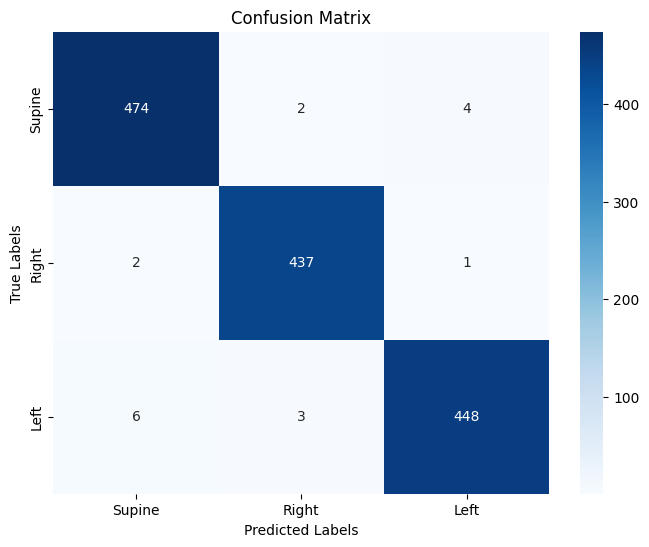

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Supine', 'Right', 'Left'], yticklabels=['Supine', 'Right', 'Left'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

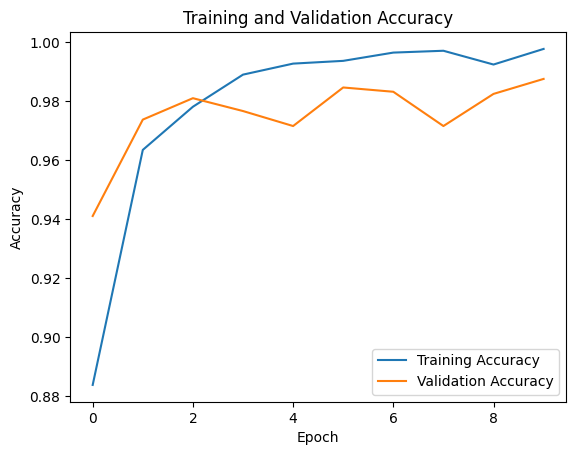

In [11]:
import matplotlib.pyplot as plt

# Assuming you have the history object from model training
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Add legend
plt.legend()

# Display the plot
plt.show()


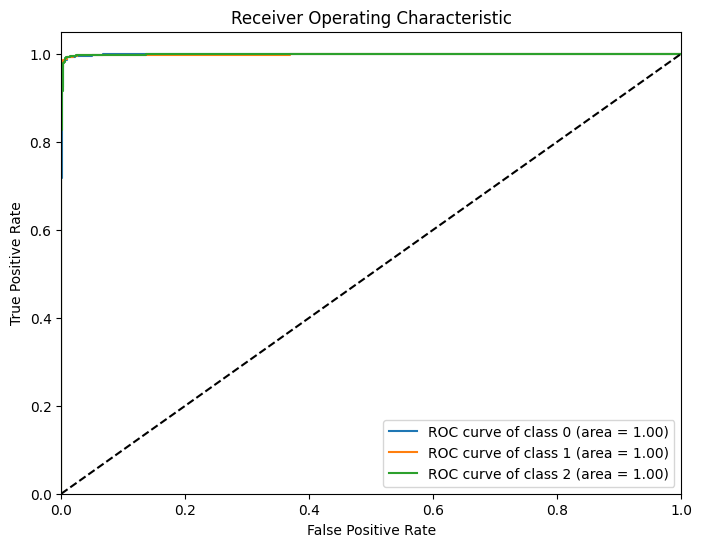

In [12]:
from sklearn.metrics import roc_curve, auc

# Binarize the output for multi-class ROC
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true_classes, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [18]:
from keras.models import model_from_json

# Save model architecture as JSON
model_json = model.to_json()
with open(r"C:\Users\deepe\OneDrive\Desktop\ImageClassificationSLP", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights(r"C:\Users\deepe\OneDrive\Desktop\ImageClassificationSLP.weights.h5")


In [16]:
import cv2
import os

def create_video_from_postures(patient_id, posture_images, output_dir, fps=1):
    # Define the output video file name with .mp4 format
    output_file = os.path.join(output_dir, f'patient_{patient_id}_postures.mp4')
    
    # Get the size of the first image to define the video frame size
    first_image = cv2.imread(posture_images[0])
    if first_image is None:
        print(f"Error reading the first image: {posture_images[0]}")
        return
    height, width, _ = first_image.shape
    
    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    video_writer = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
    
    # Loop through all posture images and write them to the video
    for img_path in posture_images:
        img = cv2.imread(img_path)
        if img is not None:
            video_writer.write(img)
        else:
            print(f"Warning: {img_path} could not be read.")
    
    # Release the video writer
    video_writer.release()
    
    # Print statement to indicate the video has been generated
    print(f"Video saved as: {output_file}")

# Example usage
def main():
    # Assuming you have 102 patients
    patients = range(1, 103)  # Patient IDs 1 to 102
    base_dir = 'D:/SLP2022/SLP/danaLab'  # Base directory for the dataset
    output_dir = 'D:/output_videos'  # Output directory for videos
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through each patient and create a video from their postures
    for patient_id in patients:
        # Construct the path to the uncover folder for the current patient
        uncover_folder = os.path.join(base_dir, f'{patient_id:05}', 'PM', 'uncover')  # Zero-pad patient ID
        
        # Generate the list of posture image file paths for the current patient
        posture_images = [
            os.path.join(uncover_folder, f'image_{i:06}.png')  # Use the correct naming convention
            for i in range(1, 46)  # Loop from 1 to 45
        ]
        
        # Create the video for the current patient
        create_video_from_postures(patient_id, posture_images, output_dir)

if __name__ == '__main__':
    main()


Video saved as: D:/output_videos\patient_1_postures.mp4
Video saved as: D:/output_videos\patient_2_postures.mp4
Video saved as: D:/output_videos\patient_3_postures.mp4
Video saved as: D:/output_videos\patient_4_postures.mp4
Video saved as: D:/output_videos\patient_5_postures.mp4
Video saved as: D:/output_videos\patient_6_postures.mp4
Video saved as: D:/output_videos\patient_7_postures.mp4
Video saved as: D:/output_videos\patient_8_postures.mp4
Video saved as: D:/output_videos\patient_9_postures.mp4
Video saved as: D:/output_videos\patient_10_postures.mp4
Video saved as: D:/output_videos\patient_11_postures.mp4
Video saved as: D:/output_videos\patient_12_postures.mp4
Video saved as: D:/output_videos\patient_13_postures.mp4
Video saved as: D:/output_videos\patient_14_postures.mp4
Video saved as: D:/output_videos\patient_15_postures.mp4
Video saved as: D:/output_videos\patient_16_postures.mp4
Video saved as: D:/output_videos\patient_17_postures.mp4
Video saved as: D:/output_videos\patient

In [6]:
import cv2
import os
import numpy as np

# Define video directory and posture labels
video_directory = 'D:/output_videos'

# Label definitions based on the second ranges
label_ranges = {
    0: (0, 14),  # Label 0: 0 to 14 seconds
    2: (15, 30),  # Label 2: 15 to 30 seconds
    1: (31, 44)   # Label 1: 31 to 44 seconds
}

# Function to preprocess a frame
def preprocess_frame(frame, target_size=(32, 64)):
    # Resize the frame to a common size
    frame_resized = cv2.resize(frame, target_size)
    # Convert the frame to a float array and normalize pixel values
    frame_array = frame_resized.astype(np.float32) / 255.0
    return frame_array

# Function to extract frames from a video and label them
def extract_frames_and_label(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    labels = []

    frame_count = 0
    fps = cap.get(cv2.CAP_PROP_FPS)  # Get frames per second
    second_frame_count = int(fps)  # Number of frames per second

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Check if the current frame count is a second mark
        if frame_count % second_frame_count == 0:
            # Calculate the current second
            current_second = frame_count // second_frame_count
            
            # Assign label based on the second ranges
            for label, (start, end) in label_ranges.items():
                if start <= current_second <= end:
                    frames.append(preprocess_frame(frame))
                    labels.append(label)
                    break

        frame_count += 1

    cap.release()

    return np.array(frames), np.array(labels)

# Lists to store all frames and labels
all_frames = []
all_labels = []

# Iterate through each video in the directory
for filename in os.listdir(video_directory):
    if filename.endswith(".mp4"):  # Check if the file is a video
        video_path = os.path.join(video_directory, filename)
        frames, labels = extract_frames_and_label(video_path)
        all_frames.extend(frames)
        all_labels.extend(labels)

# Convert lists to NumPy arrays
all_frames = np.array(all_frames)
all_labels = np.array(all_labels)

print("Shape of frames array:", all_frames.shape)
print("Shape of labels array:", all_labels.shape)


Shape of frames array: (4590, 64, 32, 3)
Shape of labels array: (4590,)


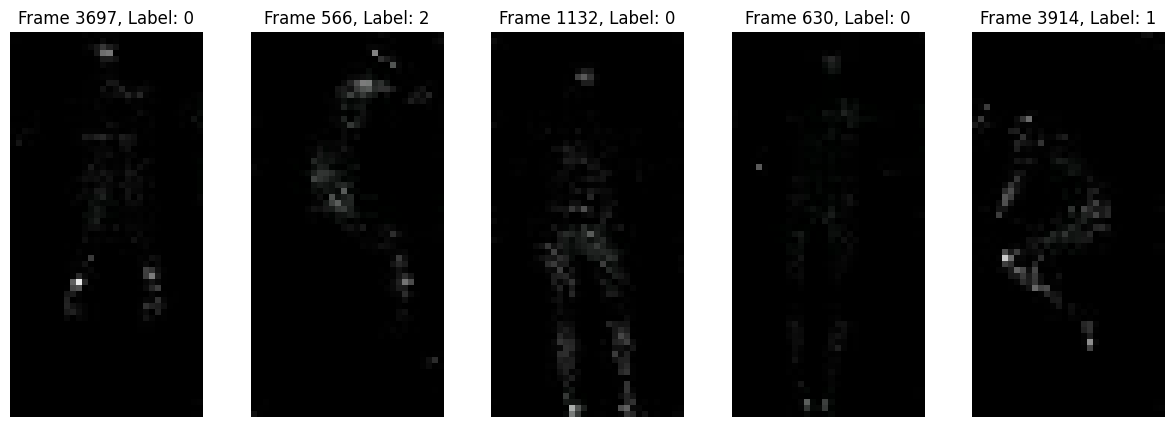

In [3]:
import matplotlib.pyplot as plt

num_samples = 5  # Number of sample frames to visualize
sample_indices = np.random.choice(len(all_frames), num_samples, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(all_frames[idx])
    plt.title(f"Frame {idx}, Label: {all_labels[idx]}")
    plt.axis('off')

plt.show()

In [7]:
import cv2
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed
from tqdm import tqdm  # Import tqdm for progress bar

# Assume all_frames and all_labels are already defined and preprocessed

# Encode labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)  # Replace 'labels' with your actual labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_frames, onehot_encoded, test_size=0.2, random_state=42)

# Define input shape for individual frames
frame_shape = (64, 32, 3)  # Height, Width, Channels

# Define the model
model = Sequential()

# Add TimeDistributed layer around convolutional layers
model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=(None,) + frame_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Flatten the output of the convolutional layers
model.add(TimeDistributed(Flatten()))

# Add LSTM layer to capture temporal dependencies
model.add(LSTM(128))  # Keras will infer input shape

# Add Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of classes based on label encoding

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test
X_train = X_train.reshape(-1, 1, 64, 32, 3)
X_test = X_test.reshape(-1, 1, 64, 32, 3)

# Train the model with a progress bar
num_epochs = 10
with tqdm(total=num_epochs, desc='Training Progress', unit='epoch') as pbar:
    history = model.fit(X_train, y_train, batch_size=32, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)
    pbar.update(num_epochs)  # Update progress bar after training is complete

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Training Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10
115/115 [==============================] - 21s 113ms/step - loss: 0.4019 - accuracy: 0.8655 - val_loss: 0.2502 - val_accuracy: 0.9129
Epoch 2/10
115/115 [==============================] - 10s 89ms/step - loss: 0.2068 - accuracy: 0.9357 - val_loss: 0.1806 - val_accuracy: 0.9444
Epoch 3/10
115/115 [==============================] - 9s 79ms/step - loss: 0.1471 - accuracy: 0.9545 - val_loss: 0.1744 - val_accuracy: 0.9488
Epoch 4/10
115/115 [==============================] - 10s 87ms/step - loss: 0.1121 - accuracy: 0.9643 - val_loss: 0.1381 - val_accuracy: 0.9597
Epoch 5/10
115/115 [==============================] - 10s 84ms/step - loss: 0.0951 - accuracy: 0.9714 - val_loss: 0.1464 - val_accuracy: 0.9564
Epoch 6/10
115/115 [==============================] - 14s 120ms/step - loss: 0.0760 - accuracy: 0.9760 - val_loss: 0.1518 - val_accuracy: 0.9542
Epoch 7/10
115/115 [==============================] - 8s 71ms/step - loss: 0.0628 - accuracy: 0.9793 - val_loss: 0.1459 - val_accuracy:

Training Progress: 100%|██████████| 10/10 [01:47<00:00, 10.76s/epoch]

 1/29 [>.............................] - ETA: 1s - loss: 0.1267 - accuracy: 0.9375

29/29 [==============================] - 1s 17ms/step - loss: 0.1737 - accuracy: 0.9542
Test Loss: 0.1736549437046051
Test Accuracy: 0.9542483687400818


In [8]:
#LSTM
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report which includes precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np



# Call the confusion_matrix function to get the actual matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Specificity for each class
specificities = []
for i in range(conf_matrix.shape[0]):
    TN = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))  # True Negatives
    FP = np.sum(np.delete(conf_matrix, i, 0)[:, i])  # False Positives
    specificity = TN / (TN + FP)
    specificities.append(specificity)

# Print specificities for each class
for i, spec in enumerate(specificities):
    print(f"Specificity for class {i}: {spec}")

# Precision, recall, F1-score, and AUC
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')  # For multi-class classification

# Print overall metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")


29/29 [==============================] - 2s 16ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       319
           1       0.93      0.95      0.94       272
           2       0.96      0.93      0.94       327

    accuracy                           0.95       918
   macro avg       0.95      0.95      0.95       918
weighted avg       0.95      0.95      0.95       918

Confusion Matrix:
[[312   4   3]
 [  2 259  11]
 [  5  17 305]]
Specificity for class 0: 0.988313856427379
Specificity for class 1: 0.9674922600619195
Specificity for class 2: 0.9763113367174281
Precision: 0.954519501984005
Recall: 0.954248366013072
F1-Score: 0.9542739287525883
AUC: 0.9906069452933574


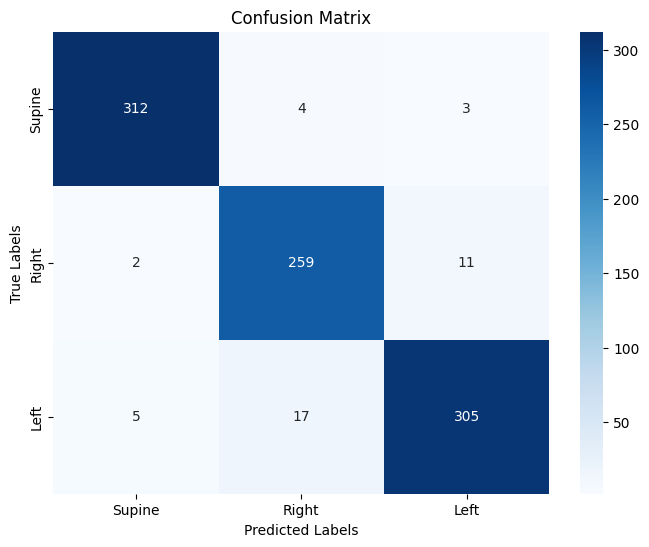

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Supine', 'Right', 'Left'], yticklabels=['Supine', 'Right', 'Left'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

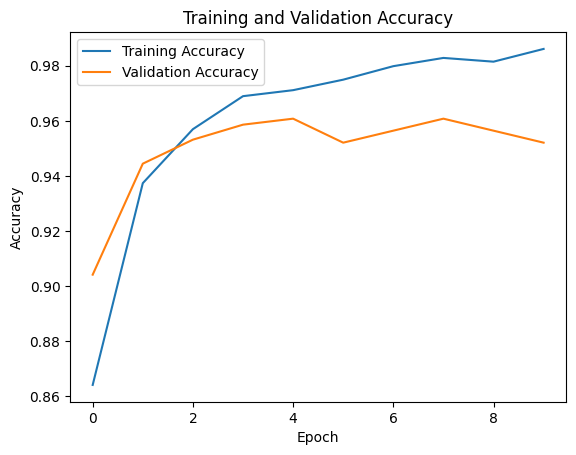

In [29]:
#LSTM
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [10]:
#SRNN
from tensorflow.keras.layers import SimpleRNN

# Define the model
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)  # Replace 'labels' with your actual labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_frames, onehot_encoded, test_size=0.2, random_state=42)

# Define input shape for individual frames
frame_shape = (64, 32, 3)  # Height, Width, Channels

model = Sequential()

# Add TimeDistributed layer around convolutional layers
model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=(None,) + frame_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Flatten the output of the convolutional layers
model.add(TimeDistributed(Flatten()))

# Add SimpleRNN layer to capture temporal dependencies
model.add(SimpleRNN(128))  # Keras will infer input shape

# Add Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of classes based on label encoding


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Reshape X_train and X_test
X_train = X_train.reshape(-1, 1, 64, 32, 3)
X_test = X_test.reshape(-1, 1, 64, 32, 3)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
115/115 [==============================] - 12s 61ms/step - loss: 0.3771 - accuracy: 0.8660 - val_loss: 0.2794 - val_accuracy: 0.9031
Epoch 2/10
115/115 [==============================] - 6s 54ms/step - loss: 0.2067 - accuracy: 0.9327 - val_loss: 0.1886 - val_accuracy: 0.9444
Epoch 3/10
115/115 [==============================] - 6s 49ms/step - loss: 0.1435 - accuracy: 0.9537 - val_loss: 0.1564 - val_accuracy: 0.9542
Epoch 4/10
115/115 [==============================] - 8s 72ms/step - loss: 0.1221 - accuracy: 0.9613 - val_loss: 0.1622 - val_accuracy: 0.9423
Epoch 5/10
115/115 [==============================] - 7s 59ms/step - loss: 0.0935 - accuracy: 0.9695 - val_loss: 0.1586 - val_accuracy: 0.9553
Epoch 6/10
115/115 [==============================] - 7s 64ms/step - loss: 0.0768 - accuracy: 0.9749 - val_loss: 0.1416 - val_accuracy: 0.9553
Epoch 7/10
115/115 [==============================] - 7s 58ms/step - loss: 0.0565 - accuracy: 0.9801 - val_loss: 0.1653 - val_accuracy: 0.960

In [11]:
#SRNN
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report which includes precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np



# Call the confusion_matrix function to get the actual matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Specificity for each class
specificities = []
for i in range(conf_matrix.shape[0]):
    TN = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))  # True Negatives
    FP = np.sum(np.delete(conf_matrix, i, 0)[:, i])  # False Positives
    specificity = TN / (TN + FP)
    specificities.append(specificity)

# Print specificities for each class
for i, spec in enumerate(specificities):
    print(f"Specificity for class {i}: {spec}")

# Precision, recall, F1-score, and AUC
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')  # For multi-class classification

# Print overall metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")


29/29 [==============================] - 1s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       319
           1       0.92      0.97      0.94       272
           2       0.98      0.93      0.95       327

    accuracy                           0.96       918
   macro avg       0.96      0.96      0.96       918
weighted avg       0.96      0.96      0.96       918

Confusion Matrix:
[[313   4   2]
 [  2 265   5]
 [  2  20 305]]
Specificity for class 0: 0.993322203672788
Specificity for class 1: 0.9628482972136223
Specificity for class 2: 0.988155668358714
Precision: 0.9630174179207885
Recall: 0.9618736383442266
F1-Score: 0.9619973835647084
AUC: 0.9895260903751568


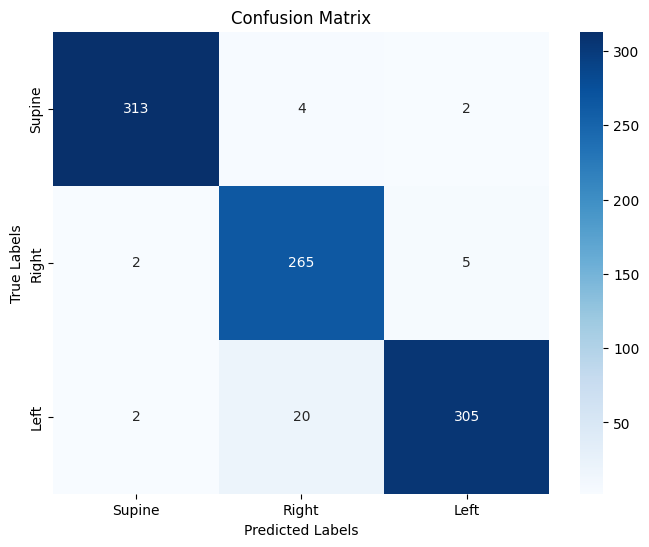

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Supine', 'Right', 'Left'], yticklabels=['Supine', 'Right', 'Left'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

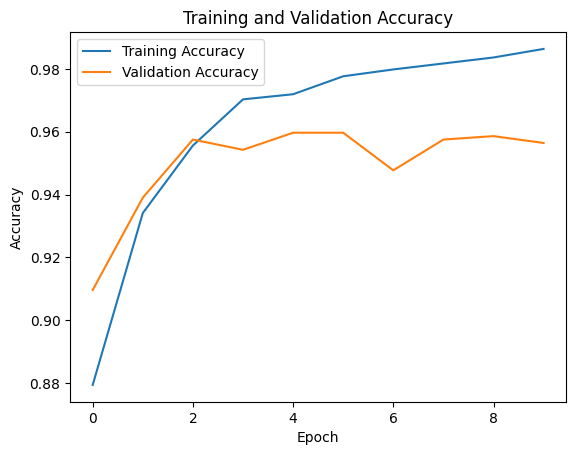

In [32]:
#srnn
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [13]:
#BLSTM
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)  # Replace 'labels' with your actual labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_frames, onehot_encoded, test_size=0.2, random_state=42)

# Define input shape for individual frames
frame_shape = (64, 32, 3)  # Height, Width, Channels

# Define the model
model = Sequential()

# Add TimeDistributed layer around convolutional layers
model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=(None,) + frame_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Flatten the output of the convolutional layers
model.add(TimeDistributed(Flatten()))

# Add Bidirectional LSTM layer to capture temporal dependencies
model.add(Bidirectional(LSTM(128)))  # Bidirectional LSTM for capturing both forward and backward dependencies

# Add Dense layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of classes based on label encoding

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test to match TimeDistributed layer's requirements
X_train = X_train.reshape(-1, 1, 64, 32, 3)
X_test = X_test.reshape(-1, 1, 64, 32, 3)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
115/115 [==============================] - 29s 148ms/step - loss: 0.4035 - accuracy: 0.8682 - val_loss: 0.2452 - val_accuracy: 0.9129
Epoch 2/10
115/115 [==============================] - 20s 173ms/step - loss: 0.1994 - accuracy: 0.9376 - val_loss: 0.1952 - val_accuracy: 0.9368
Epoch 3/10
115/115 [==============================] - 17s 149ms/step - loss: 0.1544 - accuracy: 0.9488 - val_loss: 0.1631 - val_accuracy: 0.9499
Epoch 4/10
115/115 [==============================] - 13s 113ms/step - loss: 0.1088 - accuracy: 0.9665 - val_loss: 0.1418 - val_accuracy: 0.9597
Epoch 5/10
115/115 [==============================] - 15s 133ms/step - loss: 0.0868 - accuracy: 0.9725 - val_loss: 0.1515 - val_accuracy: 0.9597
Epoch 6/10
115/115 [==============================] - 14s 122ms/step - loss: 0.0725 - accuracy: 0.9755 - val_loss: 0.1504 - val_accuracy: 0.9608
Epoch 7/10
115/115 [==============================] - 16s 140ms/step - loss: 0.0595 - accuracy: 0.9796 - val_loss: 0.1697 - val_ac

In [14]:
#BLSTM
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report which includes precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np



# Call the confusion_matrix function to get the actual matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Specificity for each class
specificities = []
for i in range(conf_matrix.shape[0]):
    TN = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))  # True Negatives
    FP = np.sum(np.delete(conf_matrix, i, 0)[:, i])  # False Positives
    specificity = TN / (TN + FP)
    specificities.append(specificity)

# Print specificities for each class
for i, spec in enumerate(specificities):
    print(f"Specificity for class {i}: {spec}")

# Precision, recall, F1-score, and AUC
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')  # For multi-class classification

# Print overall metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")


29/29 [==============================] - 3s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       319
           1       0.93      0.93      0.93       272
           2       0.97      0.92      0.95       327

    accuracy                           0.95       918
   macro avg       0.95      0.95      0.95       918
weighted avg       0.95      0.95      0.95       918

Confusion Matrix:
[[317   2   0]
 [  8 254  10]
 [  9  16 302]]
Specificity for class 0: 0.9716193656093489
Specificity for class 1: 0.9721362229102167
Specificity for class 2: 0.9830795262267343
Precision: 0.9512883483912016
Recall: 0.9509803921568627
F1-Score: 0.9507706159710189
AUC: 0.9891758240712129


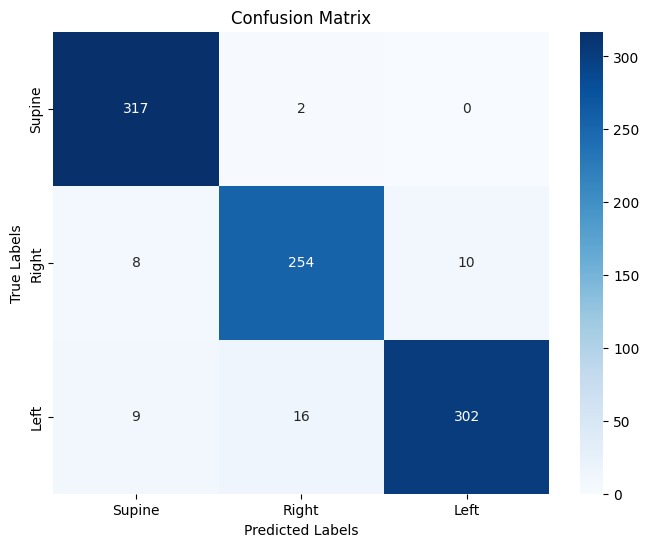

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Supine', 'Right', 'Left'], yticklabels=['Supine', 'Right', 'Left'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

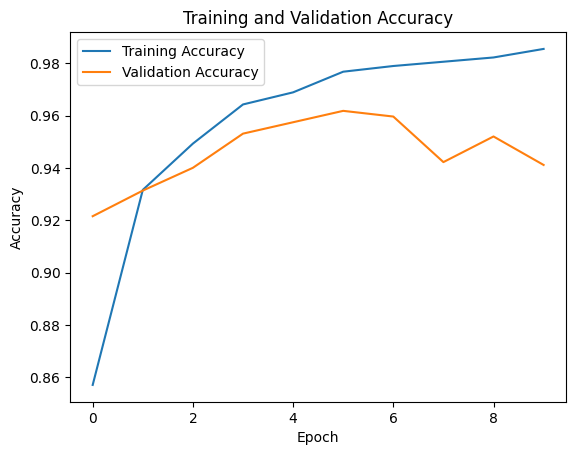

In [35]:
#BLSTM
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
